## Sample Data
---

### Recreate Features

In [1]:
%load_ext autoreload
%autoreload 2

import sys, os, json
sys.path.append('../..')
import warnings
warnings.filterwarnings(action='ignore')
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from tqdm import tqdm
import copy

plt.style.use("seaborn")

from src.utils import scale_scores
from rdsutils.lightgbm_helpers import train_lgb_baseline_grouped
from rdsutils.post_implementation_testing import plot_score_dist, get_psi, get_overlap_and_diff
from rdsutils.post_implementation_testing import plot_difference, get_combined_dfs, get_feature_comparison_report

In [2]:
ldf = pd.read_feather("../../data-transactional/labeled/labeled_1615693315.feather")
ldf.shape

(24908182, 133)

In [3]:
ldf.head()

,index,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_comment,is_return,transaction_amount,account_ending_balance,card_present_ind,...,days_to_acc_close,account_closed_by_risk_in_next_90d,last_unrestricted_date_in_next_90d,latest_acc_bal,is_chg_wrt_off_in_90d,nr_returns_in_next_90d,bal_after_90d,target,target_with_restriction,indeterminate
0,0,2017-12-13 16:26:35,37722,410000007044,ACHDD,CO,False,500.00,500.00,False,...,NaN,False,False,61317.3,False,1.0,2170.67,False,False,False
1,1,2017-12-19 23:55:21,37722,410000007044,ACHDDIN,PAYPAL VERIFYBANK,False,0.10,500.14,False,...,NaN,False,False,61317.3,False,1.0,2363.09,False,False,False
2,2,2017-12-19 23:55:21,37722,410000007044,ACHDWIN,PAYPAL VERIFYBANK,False,-0.12,500.00,False,...,NaN,False,False,61317.3,False,1.0,2363.09,False,False,False
3,3,2017-12-19 23:55:21,37722,410000007044,ACHDDIN,PAYPAL VERIFYBANK,False,0.10,500.24,False,...,NaN,False,False,61317.3,False,1.0,2363.09,False,False,False
4,4,2017-12-19 23:55:21,37722,410000007044,ACHDDIN,PAYPAL VERIFYBANK,False,0.02,500.26,False,...,NaN,False,False,61317.3,False,1.0,2363.09,False,False,False


In [4]:
ldf.transaction_code.unique()

array(['ACHDD', 'ACHDDIN', 'ACHDWIN', 'DDMBR', 'DWMBR', 'ACHDWP2P', 'DW',
       'DWACHRET', 'DDATMREFUND', 'DWATM', 'POSDW', 'DWATMI', 'DD',
       'DWCRDBILLPAY', 'DWBILLPAY', 'DDPROMO', 'DDCC', 'DDCRDBILLREF',
       'DWCK', 'DDCK', 'ACHINDD', 'POSDD', 'ACHDW', 'DPNC', 'DWTRF',
       'DDTRF', 'DDBILLPAY', 'DPND', 'DDCASHBACK', 'DDACHRET', 'DWCKCB',
       'DCWIZERO', 'DDRAFCUS', 'DDREWARDS', 'ACHRC', 'DDCHGOFF',
       'DDWRTOFF', 'DCWI', 'DDINT', 'OTID', 'DDMKT', 'ACHRD', 'DDIF',
       'DDPC', 'DDLYFTBONUS', 'DWSLROTP', 'DDCRDREWARD', 'DWWIRE',
       'DDA2ATXFR', 'DDM', 'DDPROMOBONUS', 'DDCASH', 'DDWIRE',
       'DDSLBONUS', 'DWPC', 'DWCARDREF', 'DDSAMPRBONUS', 'DDRAFNEW',
       'DDPAYOUTADJ', 'DDFRDWO', 'DBDCM', 'DCWIVAULT', 'DDCARD',
       'DDSLRBONUS', 'DDFC'], dtype=object)

In [5]:
ldf[ldf.transaction_code == "ACHINDD"].shape

(1192782, 133)

In [6]:
# interested population: those who had nr_direct_deposits
bids = ldf[ldf.nr_direct_deposits > 0].business_account_number.unique()
df = ldf[ldf.business_account_number.isin(bids)]
df.sort_values(by=["business_account_number", "transaction_datetime"], inplace=True)

In [7]:
df["pre_transaction_bal"] = df.real_ending_balance - df.transaction_amount

In [8]:
df.shape

(17465224, 134)

#### Look at some examples of when a user acct balance turns negative
---

current exact population: Currently balance more than 1000 -> 50 overdraft protection

Q: should we look at that population with balance > 1000? if so we need to add another constraint. Reason we are asking is the model didn't take in raw balance as an input.

In [9]:
# df_neg are some accounts that went negative at some point in time
bids_neg = df[df.bal_after_90d < 0].business_account_number.unique()
df_neg = df[df.business_account_number.isin(bids_neg)]

In [10]:
df_neg.groupby("business_account_number").transaction_code.count()

business_account_number
410000070530    1128
410000070911     164
410000071657     552
410000072598     920
410000072701     535
                ... 
410012516244      15
410012703407      25
410012734623      28
410013027892      14
410013102681      48
Name: transaction_code, Length: 2281, dtype: int64

In [11]:
# relevent columns for analysis
cols = ["transaction_datetime", 
        "borrower_id", 
        "business_account_number", 
        "transaction_code", 
        "is_dd", 
        "nr_direct_deposits", 
        "target", 
        "real_ending_balance",
        "transaction_amount", 
        "transaction_as_pct_of_balance",  # tamt / (ending bal - tamt)   # for expense, tamt < 0
        "bal_after_90d",
        "pre_transaction_bal"]  # newly added

In [12]:
df_ = df_neg[cols]
df_.head()

,transaction_datetime,borrower_id,business_account_number,transaction_code,is_dd,nr_direct_deposits,target,real_ending_balance,transaction_amount,transaction_as_pct_of_balance,bal_after_90d,pre_transaction_bal
4255,2017-12-20 00:00:00,3411668,410000070530,DDMBR,False,0,False,11.00,11.00,inf,341.06,0.00
4256,2017-12-20 00:00:00,3411668,410000070530,DWMBR,False,0,False,8.25,-2.75,-0.250000,341.06,11.00
4257,2017-12-29 00:00:00,3411668,410000070530,ACHDWP2P,False,0,False,205.65,-1.25,-0.006042,249.92,206.90
4258,2017-12-29 00:00:00,3411668,410000070530,ACHDWP2P,False,0,False,206.90,-1.35,-0.006483,249.92,208.25
4259,2017-12-29 12:19:00,3411668,410000070530,ACHDD,False,0,False,208.25,200.00,24.242424,301.92,8.25


In [13]:
df_.groupby("transaction_code")["transaction_amount"].median()

transaction_code
ACHDD            100.000
ACHDDIN          100.000
ACHDW           -200.000
ACHDWIN          -51.500
ACHDWP2P        -100.000
ACHINDD          418.890
ACHRC              0.000
ACHRD              0.000
DCWI               0.000
DCWIZERO           0.000
DD               158.075
DDA2ATXFR         33.015
DDACHRET          50.000
DDATMREFUND        3.000
DDBILLPAY         25.000
DDCASH           150.000
DDCASHBACK         1.530
DDCC              10.000
DDCHGOFF          80.245
DDCK             168.715
DDCRDBILLREF      34.650
DDCRDREWARD        0.720
DDFC              25.000
DDIF              20.000
DDINT              0.010
DDLYFTBONUS        2.120
DDMBR             50.000
DDMKT              5.000
DDPC              38.850
DDPROMO          100.000
DDPROMOBONUS      75.000
DDRAFCUS          50.000
DDRAFNEW          50.000
DDREWARDS          0.280
DDSAMPRBONUS      10.000
DDSLRBONUS        50.000
DDTRF             39.785
DDWRTOFF           3.580
DPNC               0.000
DPND    

In [14]:
df_[df_.real_ending_balance < 0].head(5)

,transaction_datetime,borrower_id,business_account_number,transaction_code,is_dd,nr_direct_deposits,target,real_ending_balance,transaction_amount,transaction_as_pct_of_balance,bal_after_90d,pre_transaction_bal
4914,2018-09-08 14:54:43,3411668,410000070530,POSDW,False,10,False,-23.65,-32.44,-3.690557,447.35,8.79
13394,2019-02-23 12:22:59,3033101,410000070911,POSDW,False,23,False,-25.89,-172.62,-1.176447,0.00,146.73
13395,2019-02-27 00:00:00,3033101,410000070911,DDMBR,False,23,False,-14.89,1.00,-0.062933,0.00,-15.89
13396,2019-02-27 05:50:39,3033101,410000070911,ACHDDIN,False,23,False,-15.89,10.00,-0.386250,0.00,-25.89
13411,2019-03-09 12:41:10,3033101,410000070911,POSDW,False,24,False,-82.99,-95.60,-7.581285,0.00,12.61


has_neg_bal
False    AxesSubplot(0.125,0.125;0.775x0.755)
True     AxesSubplot(0.125,0.125;0.775x0.755)
Name: clipped_tpob, dtype: object

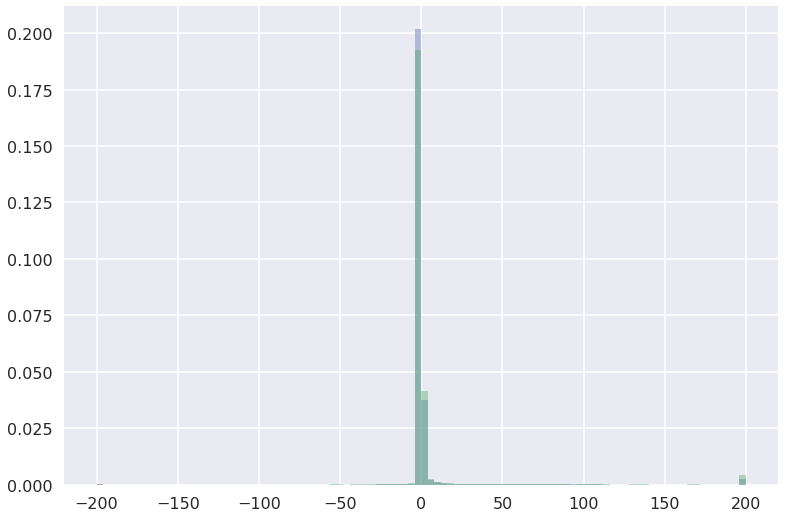

In [15]:
df_["clipped_tpob"] = df_["transaction_as_pct_of_balance"].clip(-200, 200)
df_["has_neg_bal"] = df_["bal_after_90d"] < 0
df_.groupby("has_neg_bal")["clipped_tpob"].hist(bins=100, alpha=0.4, density=True)

#### Target Population

In [16]:
# df_pop = df_neg[(df_neg.pre_transaction_bal >= 1000) & (df_neg.real_ending_balance < 0)]
# accounts with direct deposits
bids = ldf[ldf.nr_direct_deposits > 0].business_account_number.unique()
df = ldf[ldf.business_account_number.isin(bids)]

# accounts with negative balance
bids_neg = df[df.bal_after_90d < 0].business_account_number.unique()
df_neg = df[df.business_account_number.isin(bids_neg)]

df_pop = df_neg[df_neg.real_ending_balance < 0]

In [17]:
df_pop.shape

(13561, 133)

In [18]:
df_pop.index

Int64Index([    4914,    13394,    13395,    13396,    13411,    28593,
               41631,    43654,    43656,    43666,
            ...
            24832578, 24870296, 24879775, 24879778, 24879779, 24879780,
            24879781, 24879782, 24879784, 24879786],
           dtype='int64', length=13561)

Extract some typical examples of transactions that flips an account negative. Then use that to create transaction/features that will effect the model score

In [19]:
df_pop.head()

,index,transaction_datetime,borrower_id,business_account_number,transaction_code,transaction_comment,is_return,transaction_amount,account_ending_balance,card_present_ind,...,days_to_acc_close,account_closed_by_risk_in_next_90d,last_unrestricted_date_in_next_90d,latest_acc_bal,is_chg_wrt_off_in_90d,nr_returns_in_next_90d,bal_after_90d,target,target_with_restriction,indeterminate
4914,4914,2018-09-08 14:54:43,3411668,410000070530,POSDW,"WAWA 858 00008581 MARSHALLTON, DE, US",False,-32.44,-23.65,True,...,136.0,False,False,0.0,False,2.0,447.35,False,False,True
13394,13394,2019-02-23 12:22:59,3033101,410000070911,POSDW,"GAMES WORKSHOP 115-914-0000, MD, US",False,-172.62,-25.89,False,...,NaN,False,False,0.0,False,0.0,0.00,False,False,False
13395,13395,2019-02-27 00:00:00,3033101,410000070911,DDMBR,,False,1.00,-14.89,False,...,NaN,False,False,0.0,False,0.0,0.00,False,False,False
13396,13396,2019-02-27 05:50:39,3033101,410000070911,ACHDDIN,SOFI SECURITIES ACH,False,10.00,-15.89,False,...,NaN,False,False,0.0,False,0.0,0.00,False,False,False
13411,13411,2019-03-09 12:41:10,3033101,410000070911,POSDW,"GAMES WORKSHOP 115-914-0000, MD, US",False,-95.60,-82.99,False,...,NaN,False,False,0.0,False,0.0,0.00,False,False,False


In [20]:
# columns to keep from df_pop:
trn_cols = """
transaction_amount
transaction_datetime
is_return
real_ending_balance
business_account_number
created_dt
transaction_code
business_account_number
borrower_id
is_dd
""".split()
# cols_ = ["transaction_datetime", 
#         "borrower_id", 
#         "business_account_number", 
#         "transaction_code", 
#         "is_dd", 
#         "nr_direct_deposits", 
#         "target", 
#         "real_ending_balance",
#         "transaction_amount", 
#         "transaction_as_pct_of_balance",  # tamt / (ending bal - tamt)   # for expense, tamt < 0
#         "bal_after_90d",
#         "pre_transaction_bal"]
cols = list(set(trn_cols))
df_pop[cols].head()

,real_ending_balance,transaction_datetime,transaction_amount,created_dt,is_dd,transaction_code,is_return,borrower_id,business_account_number
4914,-23.65,2018-09-08 14:54:43,-32.44,NaT,False,POSDW,False,3411668,410000070530
13394,-25.89,2019-02-23 12:22:59,-172.62,NaT,False,POSDW,False,3033101,410000070911
13395,-14.89,2019-02-27 00:00:00,1.00,NaT,False,DDMBR,False,3033101,410000070911
13396,-15.89,2019-02-27 05:50:39,10.00,NaT,False,ACHDDIN,False,3033101,410000070911
13411,-82.99,2019-03-09 12:41:10,-95.60,NaT,False,POSDW,False,3033101,410000070911


In [21]:
# df_[df_.business_account_number == 410012703407]

#### Modify features
---

recipe:
1. take the last transaction for all users that has positive account balance
2. grab that user's past transactins in the past 30 days
    * to simply, we keep transactions after 2021/1/1. so the time cutoff would be 2020/12/1
3. insert a transaction with negative balance afterwards
4. rebuild the 5 transactions-based features
* ['nr_trans_ratio',
 'transaction_code_encoded',
 'transaction_as_pct_of_balance',
 'max_withdrawals_30d',
 'mean_account_balance_30d']
 
5. compare score before and after

In [22]:
bids_has_dd = ldf[ldf.nr_direct_deposits > 0].business_account_number.unique()
df_has_dd = ldf[ldf.business_account_number.isin(bids_has_dd)]
df_has_dd.shape, df_has_dd.business_account_number.nunique()

((17465224, 133), 59630)

In [23]:
# last_trn_1000 = df_has_dd[df_has_dd.real_ending_balance > 1000].drop_duplicates(subset=["business_account_number"], keep='last')

# look at all users with direct deposits with positive account balance
# originally made a mistake, and it's a waste of time to change all last_trn_1000 -> last_trn
last_trn_1000 = df_has_dd[df_has_dd.real_ending_balance > 0].drop_duplicates(subset=["business_account_number"], keep='last')
last_trn_1000 = last_trn_1000[last_trn_1000.transaction_datetime >= pd.to_datetime("2021-01-01")]
last_trn_1000.shape

(48350, 133)

In [24]:
# sample transactions... last 30 days of data
import datetime as dt

cutoff = pd.to_datetime("2021-01-01") - dt.timedelta(31)
df_ = df_has_dd[df_has_dd.transaction_datetime >= cutoff]
df_.sort_values(by=["business_account_number", "transaction_datetime"], inplace=True)

In [25]:
df_.loc[last_trn_1000.index, "keep"] = True
# df_["is_last_1000"].fillna(False, inplace=True)
df_["keep"] = df_.groupby("business_account_number")["keep"].fillna(method="bfill")
df_["keep"].fillna(False, inplace=True)
df_ = df_[df_.keep]

In [26]:
df_.loc[last_trn_1000.index, "type"] = "last_trn"
df_["type"].fillna("prev_trns", inplace=True)

In [27]:
# modify next transactions
df_to_modify = df_[df_.type == "last_trn"].copy()
df_to_modify["transaction_datetime"] = df_to_modify["transaction_datetime"] + dt.timedelta(1)
df_to_modify["transaction_code"] = np.random.choice(df_pop.transaction_code, size=len(df_to_modify))
df_to_modify["transaction_amount"] = -df_to_modify["real_ending_balance"] - np.random.random(size=len(df_to_modify)) * 50
df_to_modify["real_ending_balance"] = df_to_modify["real_ending_balance"] + df_to_modify["transaction_amount"]

# we can set types by whether it is a return: or set all of False
df_to_modify["is_return"] = np.random.choice(df_pop.is_return, size=len(df_to_modify))
df_to_modify["type"] = "modified"

In [28]:
transactions_df = pd.concat([df_, df_to_modify]).reset_index(drop=True)

In [29]:
transactions_df["type"].value_counts()

prev_trns    4493210
last_trn       48350
modified       48350
Name: type, dtype: int64

In [30]:
F = """nr_trans_ratio, transaction_code_encoded, transaction_as_pct_of_balance, max_withdrawals_30d, mean_account_balance_30d,
       nr_returns_30d, dollar_val_returns, dollar_val_returns_3d, bal_ratio""".split(",")
F = [f.strip() for f in F]
F

['nr_trans_ratio',
 'transaction_code_encoded',
 'transaction_as_pct_of_balance',
 'max_withdrawals_30d',
 'mean_account_balance_30d',
 'nr_returns_30d',
 'dollar_val_returns',
 'dollar_val_returns_3d',
 'bal_ratio']

In [31]:
from multiprocessing import Pool, cpu_count

def applyParallel(dfGrouped, func):
    """ Helper to parallelize apply over groupby """
    with Pool(cpu_count()) as p:
        ret_list = p.map(func, [group for name, group in dfGrouped])
    return pd.concat(ret_list)

def func(df_):
    print("to overwrite")


In [32]:
%%time
# nr_trans_ratio
deposit_transaction_codes = [
    "POSDD",
    "ACHDD",
    "ACHDDIN",
    "ACHINDD",
    "DDCK",
    "DDMBR",
    "DD",
]
withdrawal_transaction_codes = [
    "POSDW",
    "ACHDW",
    "ACHDWIN",
    "DWATM",
    "DWATMI",
    "DWCK",
    "DWBILLPAY",
    "DWCRDBILLPAY",
    "DWMBR",
    "ACHDWP2P",
    "DWWIRE",
    "DBDWWIRE",
    "DWTRF",
    "DBDW",
    "DWSLROTP",
    "DW",
]
transactions_df["is_trans"] = transactions_df["transaction_code"].isin(
    deposit_transaction_codes + withdrawal_transaction_codes
)

def func(df_): return df_.rolling('3d',min_periods=1,on='transaction_datetime')['is_trans'].sum()
transactions_df['nr_transactions_3d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('30d',min_periods=1,on='transaction_datetime')['is_trans'].sum()
transactions_df['nr_transactions_30d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

transactions_df["nr_trans_ratio"] = (
    transactions_df["nr_transactions_3d"] / transactions_df["nr_transactions_30d"]
)


CPU times: user 1min 11s, sys: 31.8 s, total: 1min 43s
Wall time: 1min 48s


In [33]:
%%time
# transaction_as_pct_of_balance
transactions_df["transaction_as_pct_of_balance"] = transactions_df[
        "transaction_amount"
    ] / (transactions_df["real_ending_balance"] - transactions_df["transaction_amount"])


CPU times: user 29.4 ms, sys: 25.2 ms, total: 54.6 ms
Wall time: 54 ms


In [34]:
%%time
# mean_account_balance_30d
def func(df_): return df_.rolling('30d',min_periods=1,on='transaction_datetime')['real_ending_balance'].mean()
transactions_df['mean_account_balance_30d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

CPU times: user 34.9 s, sys: 14.8 s, total: 49.8 s
Wall time: 52.4 s


In [35]:
%%time
# dollar_val_returns
transactions_df["dollar_val_returns"] = transactions_df.groupby(
    "business_account_number"
)["return_dollar_amount"].cumsum()

# dollar_val_returns_3d
def func(df_): return df_.rolling('3d',min_periods=1,on='transaction_datetime')['return_dollar_amount'].sum()
transactions_df['dollar_val_returns_3d']=applyParallel(transactions_df.groupby('business_account_number'), func).values



CPU times: user 35.2 s, sys: 14.8 s, total: 50 s
Wall time: 52.5 s


In [36]:
%%time
# bal_ratio
def func(df_): return df_.rolling('3d',min_periods=1,on='transaction_datetime')['real_ending_balance'].mean()
transactions_df['mean_account_balance_3d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

def func(df_): return df_.rolling('30d',min_periods=1,on='transaction_datetime')['real_ending_balance'].mean()
transactions_df['mean_account_balance_30d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

transactions_df["bal_ratio"] = (
    transactions_df["mean_account_balance_3d"]
    / transactions_df["mean_account_balance_30d"]
)


CPU times: user 1min 9s, sys: 30.1 s, total: 1min 39s
Wall time: 1min 43s


In [37]:
%%time
# nr_returns_30d
transactions_df["is_return"] = transactions_df["transaction_code"].isin(
    ["DWCKCB", "DWACHRET", "DDACHRET"]
) | (
    (transactions_df["transaction_code"].isin(deposit_transaction_codes))
    & (transactions_df["transaction_amount"] < 0)
)
transactions_df["nr_past_returns"] = transactions_df.groupby(
    "business_account_number"
)["is_return"].cumsum()

def func(df_): return df_.rolling('30d',min_periods=1,on='transaction_datetime')['is_return'].sum()
transactions_df['nr_returns_30d']=applyParallel(transactions_df.groupby('business_account_number'), func).values

CPU times: user 34.3 s, sys: 15.1 s, total: 49.4 s
Wall time: 51.7 s


#### Save DF

In [38]:
transactions_df.to_parquet("../../artifacts/20210313-negative-bal-on-ACHINDD/transactions_df.parquet")

In [39]:
transactions_df.shape, transactions_df.type.value_counts()

((4589910, 135),
 prev_trns    4493210
 last_trn       48350
 modified       48350
 Name: type, dtype: int64)

In [40]:
df_to_modify.is_return.value_counts()

False    47342
True      1008
Name: is_return, dtype: int64

In [41]:
mdf_before = transactions_df[transactions_df.type == "last_trn"].sort_values("borrower_id")
mdf_after = transactions_df[transactions_df.type == "modified"].sort_values("borrower_id")

In [42]:
(mdf_after.transaction_datetime.values - mdf_before.transaction_datetime.values)

array([86400000000000, 86400000000000, 86400000000000, ...,
       86400000000000, 86400000000000, 86400000000000],
      dtype='timedelta64[ns]')

In [43]:
(mdf_after.transaction_datetime.values > mdf_before.transaction_datetime.values).sum()

48350